In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, HDBSCAN
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models


2025-06-17 17:21:28.662954: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-17 17:21:28.672387: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-17 17:21:28.688581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750206088.716270 3655024 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750206088.724727 3655024 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750206088.746335 3655024 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [6]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()


In [8]:
# Prepare data
features = [
    'beam_id',
    'ra_hours',
    'dec_degrees',
    'signal_frequency',
    'signal_beam',
    'signal_drift_rate',
    'signal_snr',
    'signal_power',
    'signal_incoherent_power',
]

pd.set_option('display.max_columns', None)
df = pd.read_pickle("data/non_rfi_df.pkl")
#print(df.head(50))
df_without_incoherent = df[(df.source_name != 'Incoherent')]
df_numeric = df_without_incoherent.select_dtypes(include=[np.number]).fillna(0)
filtered_column_df = df_numeric[features]
small_df = filtered_column_df[0:3000]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(small_df)

Autoencoder

In [9]:
# Build autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 4  # size of bottleneck

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(16, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)
encoder = models.Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=32, shuffle=True, verbose=1)

X_encoded = encoder.predict(X_scaled)

Epoch 1/100


E0000 00:00:1750206182.295143 3655024 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
E0000 00:00:1750206182.295445 3655024 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
E0000 00:00:1750206182.295704 3655024 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
E0000 00:00:1750206182.295916 3655024 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1750206182.356255 3655024 gpu_device.cc:2341] Cannot

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1231
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0777
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0471
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0362
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0273
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096
Epoch 13/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091
Epoch 14/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088
Epoch 15/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085
Epoch 16/100
94/

<Figure size 1000x600 with 0 Axes>

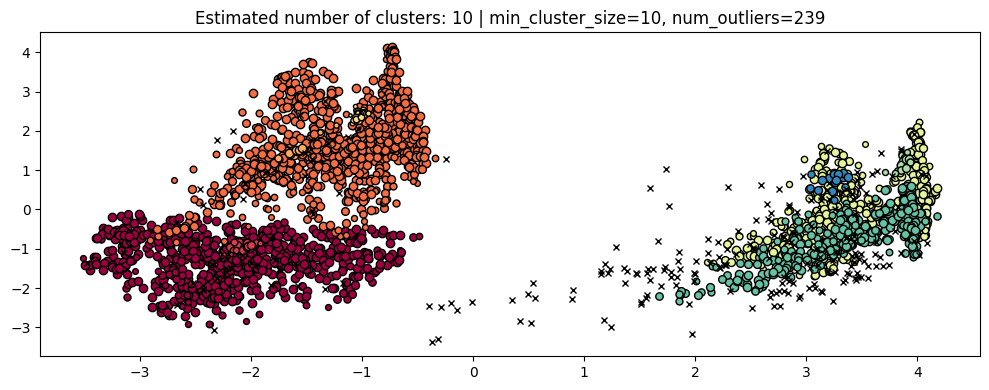

In [10]:
%matplotlib inline
plt.figure(figsize=(10,6))

X = X_encoded

clusterer = HDBSCAN(
    min_cluster_size=10,
    n_jobs=-1,
)

# Fit HDBSCAN
clusterer.fit(X)
labels = clusterer.labels_
probabilities = getattr(clusterer, "probabilities_", None)
num_outliers = np.count_nonzero(np.where(labels==-1))

# Project to 2D for visualization
X_2d = PCA(n_components=2).fit_transform(X)

# Plot clusters
plot(X_2d, labels, probabilities=probabilities, parameters={"min_cluster_size":10, "num_outliers":num_outliers})
plt.show()
